In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as MMS
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Flatten
import sys
sys.path.append('../')
from scipy.stats import norm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import os

# VAR

In [7]:
actual_invest = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_actual_loss.csv')
simu_var90 = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_simu_90.csv')
simu_var = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_simu_95.csv')
simu_var99 = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_simu_99.csv')
trad_var90 = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_trad_90.csv') 
trad_var = pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_trad_95.csv')
trad_var99 =  pd.read_csv('D:\CTS_GAN/Notebooks\VaR\First_d_CTGAN_LSTM_V6.5_trad_99.csv')

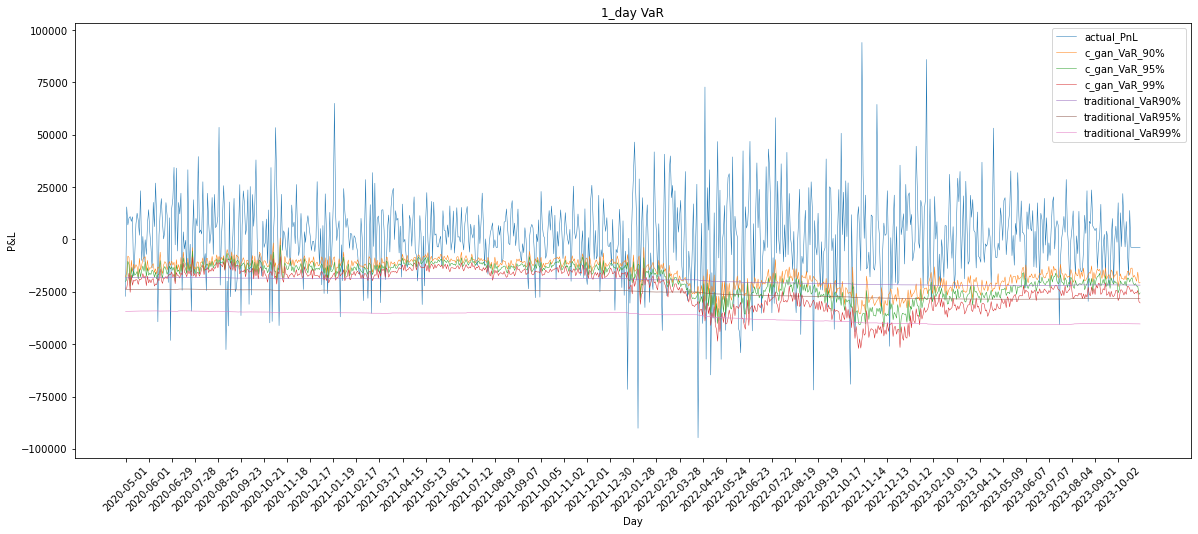

In [8]:
plt.figure(figsize=(20, 8))

plt.plot(actual_invest['Date'], actual_invest['0'].values, label='actual_PnL', linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var90['0'].values, label='c_gan_VaR_90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var['0'].values, label='c_gan_VaR_95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var99['0'].values, label='c_gan_VaR_99%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var90['0'].values, label='traditional_VaR90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var['0'].values, label='traditional_VaR95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var99['0'].values, label='traditional_VaR99%',linewidth = 0.5)
plt.title('1_day VaR')
plt.legend()
plt.xlabel("Day")
plt.ylabel("P&L")
plt.xticks(actual_invest['Date'][::20], rotation=45)
plt.show()

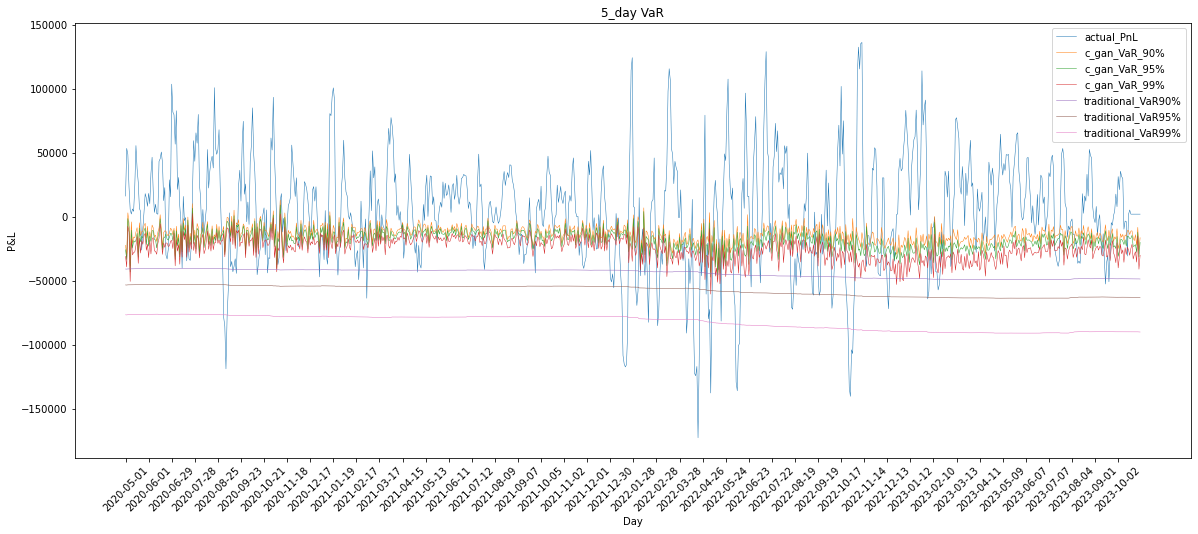

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(actual_invest['Date'], actual_invest['1'].values, label='actual_PnL', linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var90['1'].values, label='c_gan_VaR_90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var['1'].values, label='c_gan_VaR_95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var99['1'].values, label='c_gan_VaR_99%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var90['1'].values, label='traditional_VaR90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var['1'].values, label='traditional_VaR95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var99['1'].values, label='traditional_VaR99%',linewidth = 0.5)
plt.title('5_day VaR')
plt.legend()
plt.xlabel("Day")
plt.ylabel("P&L")
plt.xticks(actual_invest['Date'][::20], rotation=45)
plt.show()

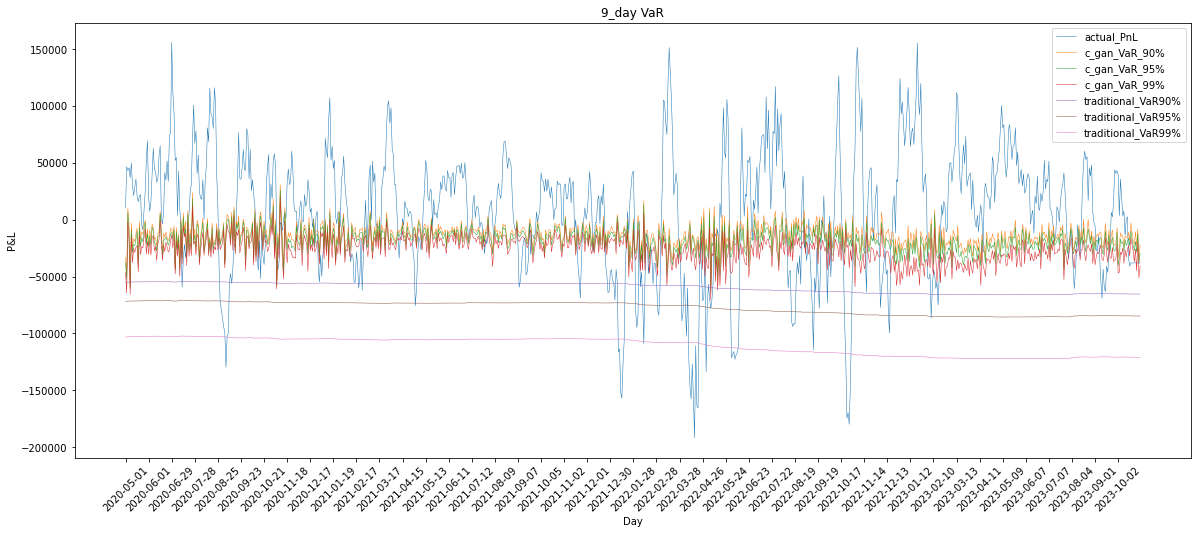

In [10]:
plt.figure(figsize=(20, 8))

plt.plot(actual_invest['Date'], actual_invest['2'].values, label='actual_PnL', linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var90['2'].values, label='c_gan_VaR_90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var['2'].values, label='c_gan_VaR_95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], simu_var99['2'].values, label='c_gan_VaR_99%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var90['2'].values, label='traditional_VaR90%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var['2'].values, label='traditional_VaR95%',linewidth = 0.5)
plt.plot(actual_invest['Date'], trad_var99['2'].values, label='traditional_VaR99%',linewidth = 0.5)
plt.title('9_day VaR')
plt.legend()
plt.xlabel("Day")
plt.ylabel("P&L")
plt.xticks(actual_invest['Date'][::20], rotation=45)
plt.show()

In [43]:
daily_df = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['0'], 'simu_var':simu_var['0'], 'trd_var':trad_var['0']})

In [44]:
daily_df

,Date,P&L,simu_var,trd_var
0,2020-05-01,-27139.985533,-20024.620544,-23880.92
1,2020-05-04,15547.093809,-19159.566447,-23917.80
2,2020-05-05,6965.236641,-10448.850198,-23856.31
3,2020-05-06,10250.482630,-12049.082891,-23848.16
4,2020-05-07,10931.576015,-22335.323157,-23842.61
...,...,...,...,...
875,2023-10-23,-3726.750611,-21096.719302,-28218.84
876,2023-10-24,-3726.750611,-22268.886723,-28218.42
877,2023-10-25,-3726.750611,-22308.705082,-28204.50
878,2023-10-26,-3726.750611,-26248.663662,-28224.57


In [87]:
def porphit(daily_df):
    print(len(daily_df[daily_df['P&L']<daily_df['simu_var']])/len(daily_df))
    print(len(daily_df[daily_df['P&L']<daily_df['trd_var']])/len(daily_df))

In [99]:
def badr(daily_df):
    ideal_simu95 = daily_df[daily_df['P&L']<daily_df['simu_var']]
    print(((ideal_simu95['P&L']-ideal_simu95['simu_var'])/1e6).mean())
    ideal_trd95 = daily_df[daily_df['P&L']<daily_df['trd_var']]
    print(((ideal_trd95['P&L']-ideal_trd95['trd_var'])/1e6).mean())

In [100]:
badr(daily_df)

-0.012793186287135596
-0.012814089395479731


In [46]:
len(daily_df[(daily_df['simu_var']>daily_df['trd_var'])&(daily_df['simu_var']<daily_df['P&L'])])/len(daily_df)

0.7272727272727273

In [88]:
porphit(daily_df)

0.13636363636363635
0.08522727272727272


In [79]:
ideal_simu95 = daily_df[daily_df['P&L']>daily_df['simu_var']]
print(((ideal_simu95['P&L']-ideal_simu95['simu_var'])/1e6).mean())
ideal_trd95 = daily_df[daily_df['P&L']>daily_df['trd_var']]
((ideal_trd95['P&L']-ideal_trd95['trd_var'])/1e6).mean()

0.025050048959603655


0.030189467173509628

In [47]:
five_df = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['1'], 'simu_var':simu_var['1'], 'trd_var':trad_var['1']})

In [48]:
five_df

,Date,P&L,simu_var,trd_var
0,2020-05-01,16055.095096,-25914.271456,-53399.37
1,2020-05-04,53333.882996,-33688.095078,-53481.82
2,2020-05-05,48541.107413,-1523.745157,-53344.34
3,2020-05-06,23188.808038,-8313.477139,-53326.10
4,2020-05-07,5556.448373,-43239.237725,-53313.69
...,...,...,...,...
875,2023-10-23,1935.754543,-21903.867300,-63099.25
876,2023-10-24,1935.754543,-27907.345450,-63098.29
877,2023-10-25,1935.754543,-12242.435403,-63067.18
878,2023-10-26,1935.754543,-31496.434359,-63112.06


In [89]:
porphit(five_df)

0.27954545454545454
0.060227272727272727


In [101]:
badr(five_df)

-0.027741973056879834
-0.03224183965449417


In [49]:
len(five_df[(five_df['simu_var']>five_df['trd_var'])&(five_df['simu_var']<five_df['P&L'])])/len(five_df)

0.7204545454545455

In [77]:
ideal_5simu95 = five_df[five_df['P&L']>five_df['simu_var']]
print(((ideal_5simu95['P&L']-ideal_5simu95['simu_var'])/1e6).mean())
ideal_5trd95 = five_df[five_df['P&L']>five_df['trd_var']]
((ideal_5trd95['P&L']-ideal_5trd95['trd_var'])/1e6).mean()

0.041182962770531496


0.06751139286061386

In [50]:
nine_df = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['2'], 'simu_var':simu_var['2'], 'trd_var':trad_var['2']})
nine_df

,Date,P&L,simu_var,trd_var
0,2020-05-01,10674.443578,-37798.250805,-71642.77
1,2020-05-04,46454.886271,-52208.409203,-71753.39
2,2020-05-05,43226.592919,6347.657056,-71568.94
3,2020-05-06,45537.085576,-9782.184852,-71544.47
4,2020-05-07,36911.798330,-60418.914898,-71527.82
...,...,...,...,...
875,2023-10-23,-38008.294830,-19085.709723,-84656.52
876,2023-10-24,-38008.294830,-28721.106545,-84655.25
877,2023-10-25,-38008.294830,-12364.569140,-84613.51
878,2023-10-26,-38008.294830,-38407.663039,-84673.72


In [51]:
len(nine_df[(nine_df['simu_var']>nine_df['trd_var'])&(nine_df['simu_var']<nine_df['P&L'])])/len(nine_df)

0.7011363636363637

In [90]:
porphit(nine_df)

0.2988636363636364
0.06477272727272727


In [102]:
badr(nine_df)

-0.04018606951641682
-0.03765183710041576


In [78]:
ideal_9simu95 =nine_df[nine_df['P&L']>nine_df['simu_var']]
print(((ideal_9simu95['P&L']-ideal_9simu95['simu_var'])/1e6).mean())
ideal_9trd95 = nine_df[nine_df['P&L']>nine_df['trd_var']]
((ideal_9trd95['P&L']-ideal_9trd95['trd_var'])/1e6).mean()

0.05176746254314416


0.09186772497973007

In [57]:
daily_df90 = pd.DataFrame({'Date':simu_var90.Date.values, 'P&L':actual_invest['0'], 'simu_var':simu_var90['0'], 'trd_var':trad_var90['0']})
daily_df90

,Date,P&L,simu_var,trd_var
0,2020-05-01,-27139.985533,-17793.716641,-18313.83
1,2020-05-04,15547.093809,-15793.975547,-18345.93
2,2020-05-05,6965.236641,-7937.076706,-18292.17
3,2020-05-06,10250.482630,-8544.027858,-18288.18
4,2020-05-07,10931.576015,-20875.331735,-18282.31
...,...,...,...,...
875,2023-10-23,-3726.750611,-18378.716023,-21779.25
876,2023-10-24,-3726.750611,-19925.425373,-21778.56
877,2023-10-25,-3726.750611,-15598.633372,-21765.26
878,2023-10-26,-3726.750611,-20827.220138,-21781.86


In [91]:
porphit(daily_df90)

0.16818181818181818
0.12613636363636363


In [104]:
badr(daily_df90)

-0.013065055427608545
-0.013301623220640818


In [58]:
len(daily_df90[(daily_df90['simu_var']>daily_df90['trd_var'])&(daily_df90['simu_var']<daily_df90['P&L'])])/len(daily_df90)

0.6511363636363636

In [80]:
ideal_simu90 = daily_df90[daily_df90['P&L']>daily_df90['simu_var']]
print(((ideal_simu90['P&L']-ideal_simu90['simu_var'])/1e6).mean())
ideal_trd90 = daily_df90[daily_df90['P&L']>daily_df90['trd_var']]
((ideal_trd90['P&L']-ideal_trd90['trd_var'])/1e6).mean()

0.022635122255215266


0.025455051206118906

In [55]:
five_df90 = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['1'], 'simu_var':simu_var90['1'], 'trd_var':trad_var90['1']})
five_df90

,Date,P&L,simu_var,trd_var
0,2020-05-01,16055.095096,-22397.333046,-40950.97
1,2020-05-04,53333.882996,-30925.554030,-41022.74
2,2020-05-05,48541.107413,2961.410836,-40902.52
3,2020-05-06,23188.808038,-5047.371081,-40893.62
4,2020-05-07,5556.448373,-38646.041783,-40880.49
...,...,...,...,...
875,2023-10-23,1935.754543,-14119.292042,-48699.87
876,2023-10-24,1935.754543,-22444.148246,-48698.34
877,2023-10-25,1935.754543,-8352.535810,-48668.61
878,2023-10-26,1935.754543,-26487.552724,-48705.71


In [105]:
badr(five_df90)

-0.02805394692345175
-0.030124863095197858


In [92]:
porphit(five_df90)

0.31931818181818183
0.09772727272727273


In [56]:
len(five_df90[(five_df90['simu_var']>five_df90['trd_var'])&(five_df90['simu_var']<five_df90['P&L'])])/len(five_df90)

0.6806818181818182

In [81]:
ideal_5simu90 = five_df90[five_df90['P&L']>five_df90['simu_var']]
print(((ideal_5simu90['P&L']-ideal_5simu90['simu_var'])/1e6).mean())
ideal_5trd90 = five_df90[five_df90['P&L']>five_df90['trd_var']]
((ideal_5trd90['P&L']-ideal_5trd90['trd_var'])/1e6).mean()

0.03937239084871025


0.05666261439575126

In [59]:
nine_df90 = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['2'], 'simu_var':simu_var90['2'], 'trd_var':trad_var90['2']})
nine_df90

,Date,P&L,simu_var,trd_var
0,2020-05-01,10674.443578,-32932.457086,-54941.50
1,2020-05-04,46454.886271,-47093.824773,-55037.78
2,2020-05-05,43226.592919,9979.996347,-54876.50
3,2020-05-06,45537.085576,-3418.379484,-54864.55
4,2020-05-07,36911.798330,-56815.128397,-54846.94
...,...,...,...,...
875,2023-10-23,-38008.294830,-10565.812924,-65337.74
876,2023-10-24,-38008.294830,-23169.894244,-65335.68
877,2023-10-25,-38008.294830,-8235.800921,-65295.79
878,2023-10-26,-38008.294830,-36252.279454,-65345.57


In [94]:
porphit(nine_df90)

0.32045454545454544
0.09772727272727273


In [106]:
badr(nine_df90)

-0.041740024615748245
-0.03958261847135542


In [62]:
len(nine_df90[(nine_df90['simu_var']>nine_df90['trd_var'])&(nine_df90['simu_var']<nine_df90['P&L'])])/len(nine_df90)

0.6772727272727272

In [82]:
ideal_9simu90 =nine_df90[nine_df90['P&L']>nine_df90['simu_var']]
print(((ideal_9simu90['P&L']-ideal_9simu90['simu_var'])/1e6).mean())
ideal_9trd90 = nine_df90[nine_df90['P&L']>nine_df90['trd_var']]
((ideal_9trd90['P&L']-ideal_9trd90['trd_var'])/1e6).mean()

0.04879132926271198


0.07699755444852738

In [63]:
daily_df99 = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['0'], 'simu_var':simu_var99['0'], 'trd_var':trad_var99['0']})
daily_df99

,Date,P&L,simu_var,trd_var
0,2020-05-01,-27139.985533,-23205.133227,-34323.86
1,2020-05-04,15547.093809,-23336.163807,-34369.70
2,2020-05-05,6965.236641,-19443.352488,-34293.73
3,2020-05-06,10250.482630,-16064.206233,-34277.74
4,2020-05-07,10931.576015,-25235.267637,-34272.80
...,...,...,...,...
875,2023-10-23,-3726.750611,-25271.696855,-40298.45
876,2023-10-24,-3726.750611,-25575.263681,-40298.51
877,2023-10-25,-3726.750611,-24360.310768,-40283.44
878,2023-10-26,-3726.750611,-29658.015556,-40310.04


In [95]:
porphit(daily_df99)

0.10227272727272728
0.038636363636363635


In [107]:
badr(daily_df99)

-0.012790952078708659
-0.012577944315932637


In [64]:
len(daily_df99[(daily_df99['simu_var']>daily_df99['trd_var'])&(daily_df99['simu_var']<daily_df99['P&L'])])/len(daily_df99)

0.8306818181818182

In [85]:
ideal_simu99 = daily_df99[daily_df99['P&L']>daily_df99['simu_var']]
print(((ideal_simu99['P&L']-ideal_simu99['simu_var'])/1e6).mean())
ideal_trd99 = daily_df99[daily_df99['P&L']>daily_df99['trd_var']]
((ideal_trd99['P&L']-ideal_trd99['trd_var'])/1e6).mean()

0.02828832982032255


0.03972119288032627

In [65]:
five_df99 = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['1'], 'simu_var':simu_var99['1'], 'trd_var':trad_var99['1']})
five_df99

,Date,P&L,simu_var,trd_var
0,2020-05-01,16055.095096,-31088.019859,-76750.49
1,2020-05-04,53333.882996,-39276.048005,-76852.98
2,2020-05-05,48541.107413,-7548.226416,-76683.11
3,2020-05-06,23188.808038,-12149.925434,-76647.37
4,2020-05-07,5556.448373,-50689.542255,-76636.30
...,...,...,...,...
875,2023-10-23,1935.754543,-27459.831548,-90110.07
876,2023-10-24,1935.754543,-35576.337343,-90110.22
877,2023-10-25,1935.754543,-15263.549426,-90076.52
878,2023-10-26,1935.754543,-41102.534231,-90135.98


In [108]:
badr(five_df99)

-0.026239208846296228
-0.029477523548508997


In [96]:
porphit(five_df99)

0.2340909090909091
0.03068181818181818


In [66]:
len(five_df99[(five_df99['simu_var']>five_df99['trd_var'])&(five_df99['simu_var']<five_df99['P&L'])])/len(five_df99)

0.7659090909090909

In [84]:
ideal_5simu99 = five_df99[five_df99['P&L']>five_df99['simu_var']]
print(((ideal_5simu99['P&L']-ideal_5simu99['simu_var'])/1e6).mean())
ideal_5trd99 = five_df99[five_df99['P&L']>five_df99['trd_var']]
((ideal_5trd99['P&L']-ideal_5trd99['trd_var'])/1e6).mean()

0.04529336548231726


0.09016501663522779

In [67]:
nine_df99 = pd.DataFrame({'Date':trad_var.Date.values, 'P&L':actual_invest['2'], 'simu_var':simu_var99['2'], 'trd_var':trad_var99['2']})
nine_df99

,Date,P&L,simu_var,trd_var
0,2020-05-01,10674.443578,-46356.026426,-102971.59
1,2020-05-04,46454.886271,-64610.821160,-103109.10
2,2020-05-05,43226.592919,-2016.491036,-102881.18
3,2020-05-06,45537.085576,-18725.006462,-102833.23
4,2020-05-07,36911.798330,-65822.210203,-102818.39
...,...,...,...,...
875,2023-10-23,-38008.294830,-25813.354024,-120895.35
876,2023-10-24,-38008.294830,-44866.163259,-120895.54
877,2023-10-25,-38008.294830,-19891.182763,-120850.33
878,2023-10-26,-38008.294830,-51218.072138,-120930.11


In [97]:
porphit(nine_df99)

0.2556818181818182
0.03295454545454545


In [109]:
badr(nine_df99)

-0.03895911855878106
-0.027886609406015627


In [68]:
len(nine_df99[(nine_df99['simu_var']>nine_df99['trd_var'])&(nine_df99['simu_var']<nine_df99['P&L'])])/len(nine_df99)

0.7443181818181818

In [83]:
ideal_9simu99 =nine_df99[nine_df99['P&L']>nine_df99['simu_var']]
print(((ideal_9simu99['P&L']-ideal_9simu99['simu_var'])/1e6).mean())
ideal_9trd99 = nine_df99[nine_df99['P&L']>nine_df99['trd_var']]
((ideal_9trd99['P&L']-ideal_9trd99['trd_var'])/1e6).mean()

0.056470821873816864


0.12194446437881157

In [47]:
def porportion_cal(df, col):
    return len(df[df['P&L']<df[col]])/len(df)

In [48]:
for col in ['simu_var', 'trd_var']:
    print(porportion_cal(daily_df, col))

0.1722488038277512
0.09569377990430622


In [49]:
for col in ['simu_var', 'trd_var']:
    print(porportion_cal(five_df, col))

0.215311004784689
0.023923444976076555


In [50]:
for col in ['simu_var', 'trd_var']:
    print(porportion_cal(fourteen_df, col))

0.16267942583732056
0.03349282296650718
